In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model, svm
import matplotlib.pyplot as plt
import time
import sys
sys.path.append("../")
%load_ext autoreload
%autoreload 2
from src.reachset.reachset_io import read_reachset

C:\Users\ktomita3\.conda\envs\learn-reach\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data_path = "C:/Users/ktomita3/Documents/001_workspace/rahao/out/20230803_021318/reachset_sample_10000.json"
#data_path = "C:/Users/ktomita3/Documents/001_workspace/rahao/out/20230803_021318/reachset.json"

In [5]:
rocket, N, reachset = read_reachset(fpath=data_path, nmax=None)

In [6]:
xmin_list = []
xmax_list = []
feasible_ic = []  # alt, v-horizontal, v-vertical, mass, tgo
infeasible_ic = []  # alt, v-horizontal, v-vertical, mass, tgo
all_ic = []
feasibility = []
for data in reachset:
    x0 = data["x0"]
    tgo = data["tgo"]
    ic = [x0[2], x0[3], x0[5], x0[6], tgo[0]]
    all_ic.append(ic)

    # check feasibility
    xs = data["rf"][:,0]
    if np.all(np.isnan(xs)):  # infeasible
        infeasible_ic.append(ic)
        feasibility.append(0)
    else:  # feasible
        feasible_ic.append(ic)
        xmin_list.append(data["rf"][0][0])
        xmax_list.append(data["rf"][-1][0])
        feasibility.append(1)

print(f"Total: {reachset.size}, Feasible: {len(feasible_ic)}, Infeasible: {len(infeasible_ic)}")

infeasible_ic = np.array(infeasible_ic)
feasible_ic = np.array(feasible_ic)
all_ic = np.array(all_ic)
feasibility = np.array(feasibility)

Total: 10000, Feasible: 3289, Infeasible: 6711


### ML for Feasibility Prediction

In [7]:
X, y = all_ic, feasibility

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Classifier names
names = [
    "Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process",
    "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
    "Naive Bayes", "QDA"
]

# Classifier instances
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42), # GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

# Create a classification dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Function to evaluate classifiers
def evaluate_classifier(clf, X_train, X_test, y_train, y_test):
    start_time = time.time()
    clf.fit(X_train, y_train)
    fit_time = time.time() - start_time

    start_time = time.time()
    y_pred = clf.predict(X_test)
    predict_time = time.time() - start_time

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    memory = sys.getsizeof(clf)

    return accuracy, precision, recall, f1, fit_time, predict_time, memory

# Print the results in a table-like format
print(f"{'Classifier':<20} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1 Score':>10} {'Fit Time':>10} {'Predict Time':>14} {'Memory (Bytes)':>15}")
for name, clf in zip(names, classifiers):
    clf = make_pipeline(StandardScaler(), clf)
    accuracy, precision, recall, f1, fit_time, predict_time, memory = evaluate_classifier(clf, X_train, X_test, y_train, y_test)

    print(f"{name:<20} {accuracy:>10.2f} {precision:>10.2f} {recall:>10.2f} {f1:>10.2f} {fit_time:>10.2f}s {predict_time:>10.2f}s {memory:>15}")


Classifier             Accuracy  Precision     Recall   F1 Score   Fit Time   Predict Time  Memory (Bytes)
Nearest Neighbors          0.96       0.93       0.94       0.94       0.01s       0.13s              48
Linear SVM                 0.92       0.87       0.90       0.89       0.17s       0.08s              48
RBF SVM                    0.98       0.96       0.96       0.96       0.28s       0.43s              48
Decision Tree              0.93       0.89       0.90       0.90       0.03s       0.00s              48
Random Forest              0.92       0.91       0.86       0.88       0.06s       0.00s              48
Neural Net                 0.97       0.93       0.96       0.95       2.66s       0.00s              48
AdaBoost                   0.93       0.88       0.91       0.89       0.48s       0.02s              48
Naive Bayes                0.90       0.88       0.81       0.85       0.00s       0.00s              48
QDA                        0.94       0.90       0.91

In [21]:
gamma_list = [0.1, 2.0, 10.0]
C_list = [0.01, 1.0, 100.0]

print(f"{'Classifier':<20} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1 Score':>10} {'Fit Time':>10} {'Predict Time':>14} {'Memory (Bytes)':>15}")
from itertools import product
for gamma, C in product(gamma_list, C_list):
    model = SVC(gamma=gamma, C=C, random_state=42)
    clf = make_pipeline(StandardScaler(), model)
    accuracy, precision, recall, f1, fit_time, predict_time, memory = evaluate_classifier(clf, X_train, X_test, y_train, y_test)

    print(f"SVM (gamma={gamma:>5.2f}, C={C:>5.2f}), {accuracy:>10.2f} {precision:>10.2f} {recall:>10.2f} {f1:>10.2f} {fit_time:>10.2f}s {predict_time:>10.2f}s {memory:>15}")


Classifier             Accuracy  Precision     Recall   F1 Score   Fit Time   Predict Time  Memory (Bytes)
SVM (gamma= 0.10, C= 0.01),       0.91       0.93       0.78       0.85       0.52s       0.93s              48
SVM (gamma= 0.10, C= 1.00),       0.97       0.95       0.96       0.95       0.17s       0.31s              48
SVM (gamma= 0.10, C=100.00),       0.98       0.97       0.98       0.97       0.10s       0.11s              48
SVM (gamma= 2.00, C= 0.01),       0.70       1.00       0.11       0.20       0.69s       1.19s              48
SVM (gamma= 2.00, C= 1.00),       0.98       0.96       0.96       0.96       0.27s       0.43s              48
SVM (gamma= 2.00, C=100.00),       0.97       0.95       0.97       0.96       0.22s       0.26s              48


C:\Users\ktomita3\.conda\envs\learn-reach\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM (gamma=10.00, C= 0.01),       0.67       0.00       0.00       0.00       0.90s       1.64s              48
SVM (gamma=10.00, C= 1.00),       0.94       0.97       0.85       0.91       1.24s       1.59s              48
SVM (gamma=10.00, C=100.00),       0.95       0.96       0.87       0.91       1.31s       1.56s              48


In [26]:
model.support_vectors_.shape

(3005, 5)

In [25]:
model = svm.NuSVC(gamma="auto")
clf = make_pipeline(StandardScaler(), model)
accuracy, precision, recall, f1, fit_time, predict_time, memory = evaluate_classifier(clf, X_train, X_test, y_train, y_test)

print(f"SVM (gamma={gamma:>5.2f}, C={C:>5.2f}), {accuracy:>10.2f} {precision:>10.2f} {recall:>10.2f} {f1:>10.2f} {fit_time:>10.2f}s {predict_time:>10.2f}s {memory:>15}")

SVM (gamma=10.00, C= 1.00),       0.91       0.94       0.79       0.86       0.73s       0.88s              48


In [221]:
Y = np.nan_to_num(xmin_list, nan=1.0)
#Y = np.nan_to_num(xmax_list, nan=0.0)
Y = Y/X[:, 0]/np.tan(rocket.fov/2)

In [210]:
def r_squared(y, y_pred):
    y_mean = np.mean(y_pred)
    return 1 - np.sum((y_pred - y)**2)/np.sum((y_pred - y_mean)**2)

def analyze_model(y, y_pred):
    print(f"RMSE: {np.sqrt(np.mean((y_pred - y)**2)):.3f}, R^2: {r_squared(y, y_pred):.3f}")
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot(y, y, color='r')
    plt.title("Predictions vs. Actual")
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")

    plt.subplot(1,2,2)
    plt.scatter(Y, Y_fitted-Y, alpha=0.8)
    plt.title("Predictions vs. Actual")
    plt.xlabel("Actual values")
    plt.ylabel("Pred - True")
    

In [166]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn import tree
import numpy as np

RMSE: 0.239, R^2: 0.767


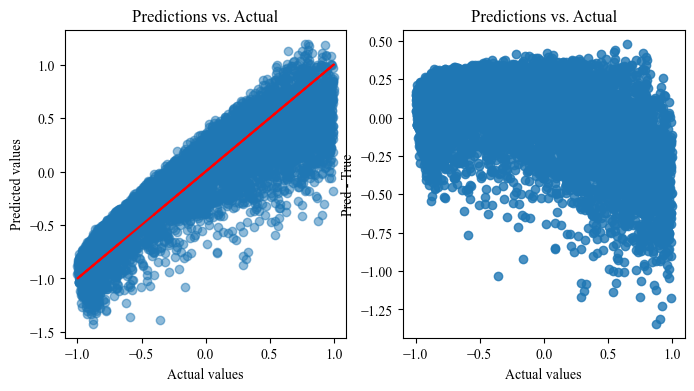

In [222]:
model = linear_model.Lasso(alpha=0.1)
model = model.fit(X, Y)
Y_fitted = model.predict(X)
analyze_model(Y, Y_fitted)

RMSE: 0.217, R^2: 0.797


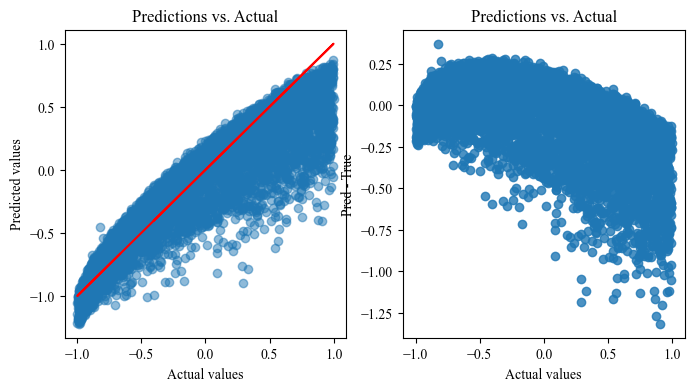

In [223]:
model = svm.SVR()
model = model.fit(X, Y)
Y_fitted = model.predict(X)
analyze_model(Y, Y_fitted)

RMSE: 0.118, R^2: 0.955


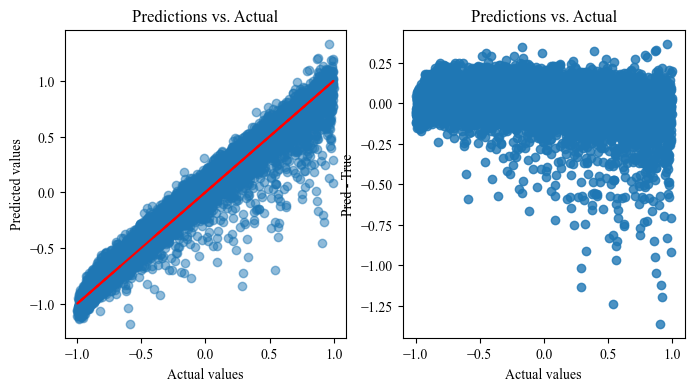

In [224]:
model = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', LinearRegression(fit_intercept=False))])
model = model.fit(X, Y)
Y_fitted = model.predict(X)
analyze_model(Y, Y_fitted)

RMSE: 0.165, R^2: 0.907


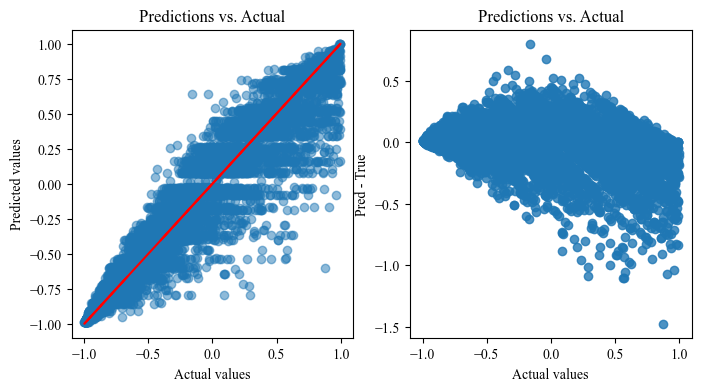

In [225]:
model = tree.DecisionTreeRegressor(max_depth=8)
model = model.fit(X, Y)
Y_fitted = model.predict(X)
analyze_model(Y, Y_fitted)

RMSE: 0.348, R^2: 0.593


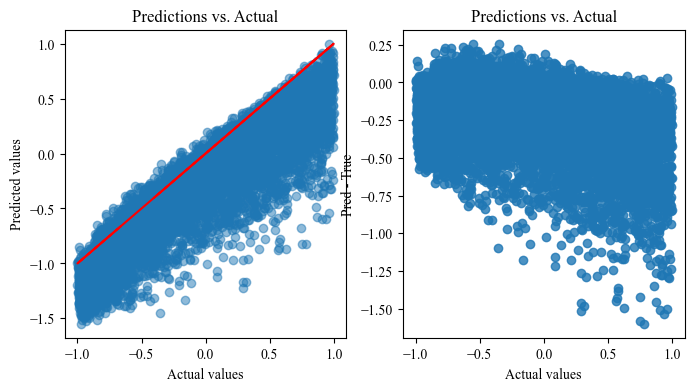

In [227]:
model = MLPRegressor(hidden_layer_sizes=(100, 100, 100), random_state=1, max_iter=5000)
model = model.fit(X, Y)
Y_fitted = model.predict(X)
analyze_model(Y, Y_fitted)

In [192]:
#reg = linear_model.Lasso(alpha=0.1)
#model = svm.SVR()
#model = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', LinearRegression(fit_intercept=False))])
#model = tree.DecisionTreeRegressor(max_depth=8)
model = MLPRegressor(hidden_layer_sizes=(5, 5, 5), random_state=10, max_iter=5000)
model = model.fit(X, Y)

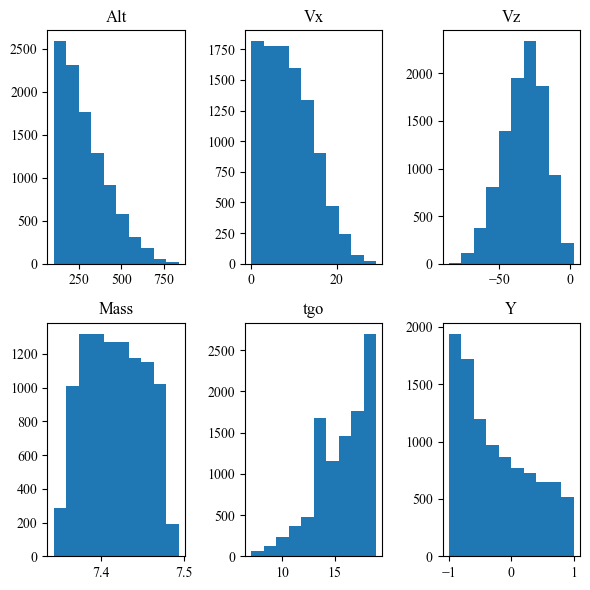

In [228]:
plt.figure(figsize=(6, 6))

plt.subplot(2, 3, 1)
plt.hist(X[:, 0])
plt.title("Alt")
plt.subplot(2, 3, 2)
plt.hist(X[:, 1])
plt.title("Vx")
plt.subplot(2, 3, 3)
plt.hist(X[:, 2])
plt.title("Vz")
plt.subplot(2, 3, 4)
plt.hist(X[:, 3])
plt.title("Mass")
plt.subplot(2, 3, 5)
plt.hist(X[:, 4])
plt.title("tgo")
plt.subplot(2, 3, 6)
plt.hist(Y)
plt.title("Y")

plt.tight_layout()
plt.show()